In [1]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from math import pi, cos, sin
import matplotlib.pyplot as plt
import cv2 as cv

def draw_at(x,y):
    image = Image.new('RGB', (60, 300), (255,255,255))
    draw = ImageDraw.Draw(image)
    spring_y = lambda t: t * y / (5*pi) - 8 * cos(3*t) - 30
    spring_x = lambda t: x + 20 * sin(3*t)
    draw.line([(spring_x(t),spring_y(t)) for t in np.linspace(0,5*pi,100)], fill='black', width=1)
    draw.line([(x,y-22),(x,y)], fill='black', width=1)
    draw.ellipse((x-10, y-10, x+10,y+10), fill = 'green')
    return image

def y(t): 
    return 150 - 75 * cos(5*t)

def frame(y,t):
    return draw_at(30,y(t))
    

frame(y,0)

spring_comic_strip_images = [frame(y,t) for t in np.linspace(0,2,21)]

def comic_strip(images,coords=None):
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))
    draw = ImageDraw.Draw(new_im)
    x_offset = 0
    
    for i,im in enumerate(images):
        new_im.paste(im, (x_offset,0))
        draw.line([(x_offset,0),(x_offset,max_height)], fill=(230,230,230))
        x_offset += im.size[0]
        if coords:
            font = ImageFont.truetype("CourierStd.otf",size=16)
            draw.text((x_offset-im.size[0]+5,max_height-40),"x={}".format(coords[i][0]),(0,0,0),font=font)
            draw.text((x_offset-im.size[0]+5,max_height-20),"y={}".format(coords[i][1]),(0,0,0),font=font)
    
    return new_im

# https://stackoverflow.com/questions/43048725/python-creating-video-from-images-using-opencv
def video(video_name,get_frame,tstart,tend):
    imgs = []
    t = tstart
    dt = 1/30
    while t <= tend:
        # https://stackoverflow.com/questions/14134892/convert-image-from-pil-to-opencv-format
        pil_image = get_frame(t)
        open_cv_image = np.array(pil_image) 
        # Convert RGB to BGR 
        open_cv_image = open_cv_image[:, :, ::-1].copy()
#         cv.imshow('foo',open_cv_image)
#         cv.waitKey(0)
#         cv.destroyAllWindows()
        imgs.append(open_cv_image)
        t += dt
    height, width, layers = imgs[0].shape
    
    # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_video_display/py_video_display.html
    fourcc = cv.VideoWriter_fourcc(*'XVID')
    video = cv.VideoWriter(video_name,fourcc, 30.0, (width,height))
    for img in imgs:
        video.write(img)
        
    
    video.release()
    
    
def get_video_frames(video_name):
    cap = cv.VideoCapture(video_name)
    imgs = []
    while True:
        ret,frame = cap.read()
        if ret:
            imgs.append(Image.fromarray(cv.cvtColor(frame, cv.COLOR_BGR2RGB)))
        else:
            break
    return imgs

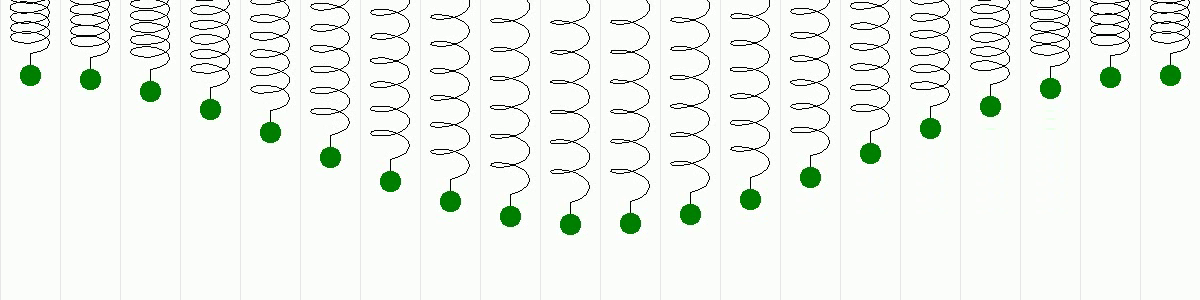

In [2]:
imgs = get_video_frames('spring.avi')
comic_strip([imgs[2*i] for i in range(0,20)])

In [3]:
video('spring.avi', lambda t:frame(y,t), 0,10)

In [4]:
import cv2 as cv
import numpy as np

# https://docs.opencv.org/3.4/db/df8/tutorial_py_meanshift.html
def track(video_name,vid_dimensions):

    vid_width, vid_height = vid_dimensions
    
    cap = cv.VideoCapture(video_name)
    framerate = cap.get(cv.CAP_PROP_FPS)
    # take first frame of the video
    ret,frame = cap.read()
    
    # initialize output video
    height, width, layers = frame.shape
    out_video_name = 'meanshift_' + video_name
    fourcc = cv.VideoWriter_fourcc(*'XVID')
    video = cv.VideoWriter(out_video_name,fourcc, framerate, (width,height))
    
    #mess with first image
    
    global topleft, bottomright, drawing, done_setting_bounding_box
    done_setting_bounding_box = False
    drawing = False
    topleft = ()
    bottomright = ()

    def mouse_drawing(event, x, y, flags, params):
        # https://pysource.com/2018/03/27/mouse-events-opencv-3-4-with-python-3-tutorial-27/
        global topleft, bottomright, drawing, done
        if not done_setting_bounding_box:
            if event == cv.EVENT_LBUTTONDOWN:
                if drawing is False:
                    drawing = True
                    topleft = (x, y)
                else:
                    drawing = False

            elif event == cv.EVENT_MOUSEMOVE:
                if drawing is True:
                    bottomright = (x, y)

            if topleft and bottomright:
                f = frame.copy()
                cv.rectangle(f, topleft, bottomright, (255, 0, 0))
                cv.imshow('first frame', f)

    cv.namedWindow('first frame')
    cv.setMouseCallback('first frame', mouse_drawing)
                
    # https://stackoverflow.com/questions/46671348/make-a-pause-between-images-display-in-opencv
    cv.imshow('first frame', frame)
    k = cv.waitKey(0)
    done_setting_bounding_box = True
    
    # setup initial location of window
    t=0
    initial_bounding_box = (topleft[0],topleft[1],bottomright[0]-topleft[0],bottomright[1]-topleft[1])
    h,r,c,w = initial_bounding_box  # simply hardcoded the values
    track_window = (c,r,w,h)
    # set up the ROI for tracking
    roi = frame[r:r+h, c:c+w]
    hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
    mask = cv.inRange(hsv_roi, np.array((50., 50.,0.)), np.array((255.,255.,150)))
    roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
    cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)
    # Setup the termination criteria, either 10 iteration or move by atleast 1 pt
    term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )
    
    def x_center(window):
        c,r,w,h = window
        return (c + w/2) * vid_width/width
    
    def y_center(window):
        c,r,w,h = window
        return vid_height - (r + h/2) * vid_height/height
    
    results = [(t, x_center(track_window), y_center(track_window))]
    
    while(1):
        t += 1/framerate
        ret ,frame = cap.read()
        if ret == True:
            hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
            dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
            # apply meanshift to get the new location
            ret, track_window = cv.meanShift(dst, track_window, term_crit)
            results.append((t, x_center(track_window), y_center(track_window)))
            # Draw it on image
            x,y,w,h = track_window
            img2 = cv.rectangle(frame, (x,y), (x+w,y+h), (255, 0, 0))
#             cv.imshow('img2',img2)
#             if k == 27:
#                 break
#             else:
#                 cv.imwrite(chr(k)+".jpg",img2)
            cv.imshow('first frame', img2)
            cv.waitKey(int(1000/framerate))
            video.write(img2)
        else:
            break
    video.release()
    cv.destroyAllWindows()
    cap.release()
    return [w[0] for w in results], [w[1] for w in results], [w[2] for w in results]

# spring_ts,spring_xs,spring_ys = track('spring.avi',(0.2,1.0))

In [5]:
spring_ts,spring_xs,spring_ys = track('spring.avi',(0.2,1.0))
len(spring_ts)

301

Text(0,0.5,'Y Position (meters)')

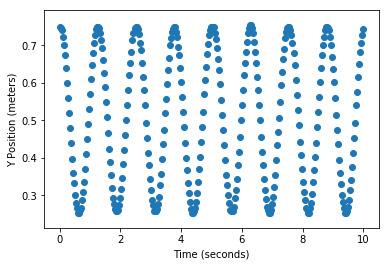

In [6]:
plt.scatter(spring_ts,spring_ys)
plt.xlabel('Time (seconds)')
plt.ylabel('Y Position (meters)')

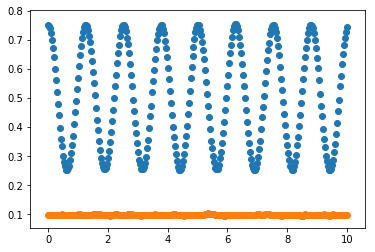

In [7]:
import matplotlib.pyplot as plt
plt.scatter(spring_ts,spring_ys)
plt.scatter(spring_ts,spring_xs)

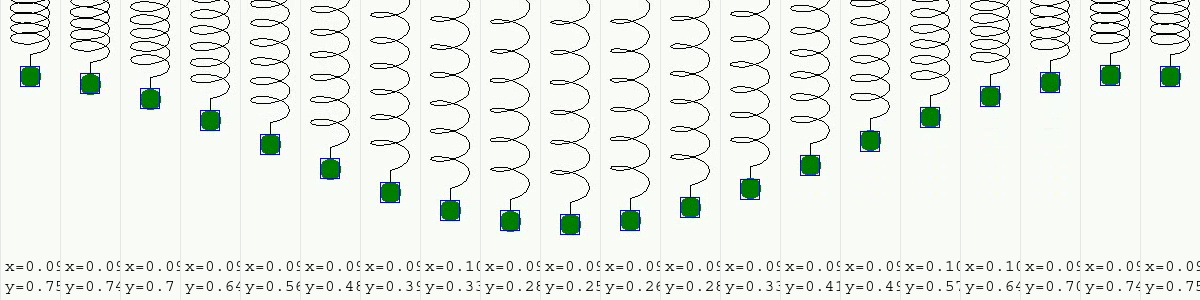

In [8]:
imgs = get_video_frames('meanshift_spring.avi')
coords = list(zip(spring_xs,spring_ys))
comic_strip([imgs[2*i] for i in range(0,20)],[coords[2*i] for i in range(0,20)])

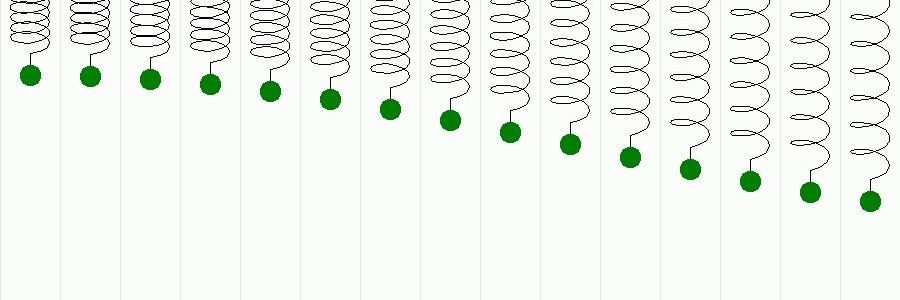

In [9]:
comic_strip(get_video_frames('spring.avi')[0:15])

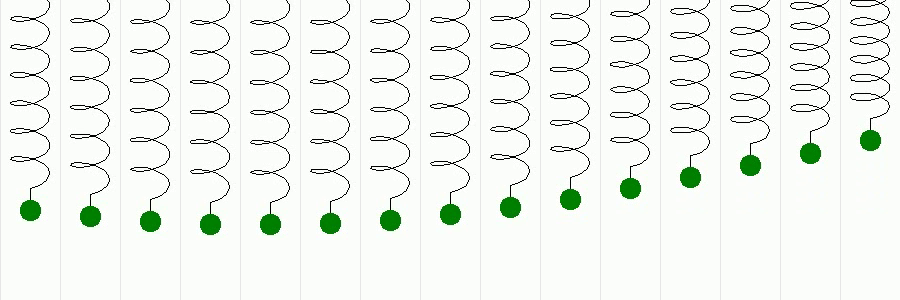

In [10]:
comic_strip(get_video_frames('spring.avi')[15:30])

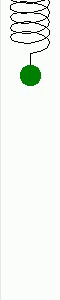

In [11]:
comic_strip(get_video_frames('spring.avi')[0:1])

In [12]:
vy = [(spring_ys[i+1] - spring_ys[i])/(spring_ts[i+1] - spring_ts[i]) for i in range(0,len(spring_ts)-1)]

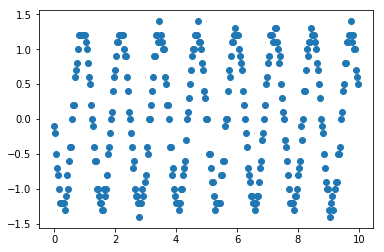

In [13]:
plt.scatter(spring_ts[:-1],vy)

In [14]:
ay = [(vy[i+1] - vy[i])/(spring_ts[i+1] - spring_ts[i]) for i in range(0,len(vy)-1)]

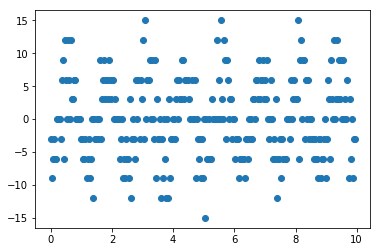

In [15]:
plt.scatter(spring_ts[:-2],ay)

In [16]:
second1 = [(t,y) for (t,y) in zip(spring_ts,spring_ys) if 0.5 <= t <= 0.8]

Text(0,0.5,'Y Position (meters)')

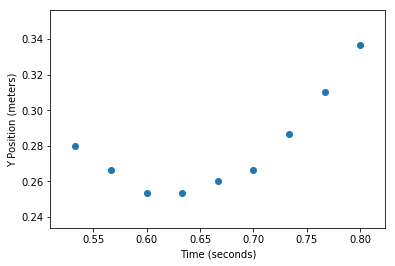

In [17]:
plt.scatter([t for (t,y) in second1], [y for (t,y) in second1])
plt.xlabel('Time (seconds)')
plt.ylabel('Y Position (meters)')

In [18]:
second1[-1]

(0.7999999999999999, 0.33666666666666667)

In [19]:
second1[-2:]

[(0.7666666666666666, 0.31000000000000005),
 (0.7999999999999999, 0.33666666666666667)]

In [20]:
0.31 - 0.286

0.02400000000000002

In [21]:
second1[:2]

[(0.5333333333333333, 0.28), (0.5666666666666667, 0.2666666666666667)]

In [22]:
second1[1][1] - second1[0][1]

-0.013333333333333308

In [23]:
(second1[1][1] - second1[0][1])/(second1[1][0] - second1[0][0])

-0.39999999999999936

In [24]:
(second1[-1][1] - second1[-2][1])/(second1[-1][0] - second1[-2][0])

0.7999999999999987

Text(0,0.5,'Y Position (meters)')

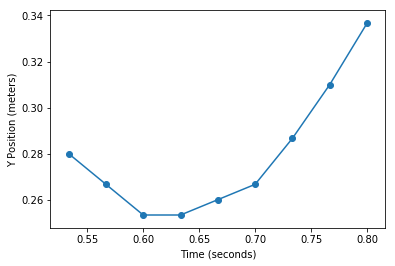

In [25]:
plt.plot([t for (t,y) in second1], [y for (t,y) in second1])
plt.scatter([t for (t,y) in second1], [y for (t,y) in second1])
plt.xlabel('Time (seconds)')
plt.ylabel('Y Position (meters)')

In [26]:
def interval_velocity(t1,x1,t2,x2):
    return (x2 - x1) / (t2 - t1)

In [27]:
def all_interval_velocities(ts,xs):
    return [
        interval_velocity(ts[i],xs[i],ts[i+1],xs[i+1])
        for i in range(0,len(ts) - 1)
    ]

In [28]:
spring_vys = all_interval_velocities(spring_ts,spring_ys)

Text(0.5,0,'Interval start time (s)')

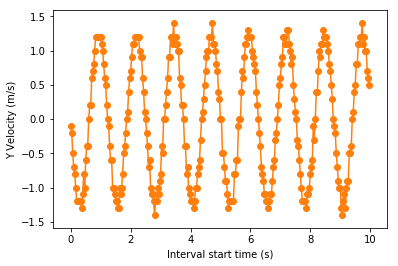

In [29]:
plt.plot(spring_ts[:-1],spring_vys,c='C1')
plt.scatter(spring_ts[:-1],spring_vys,c='C1')
plt.ylabel('Y Velocity (m/s)')
plt.xlabel('Interval start time (s)')

In [30]:
def y(t):
    return 0.5 + 0.25 * cos(5*t)
def n_points_of_y(n):
    ts = np.linspace(0.5,0.8,n)
    plt.scatter(ts,[y(t) for t in ts])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Y Position (meters)')
    plt.title('{} Position Measurements'.format(n))

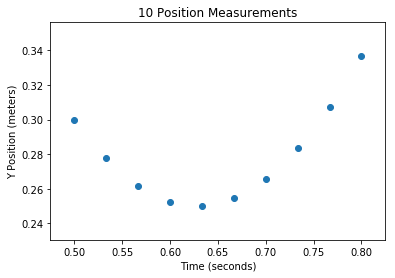

In [31]:
n_points_of_y(10)

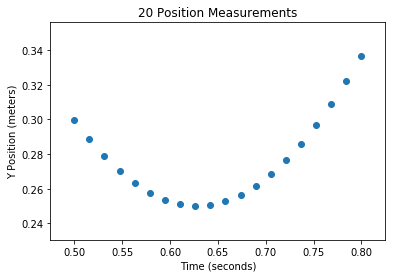

In [32]:
n_points_of_y(20)

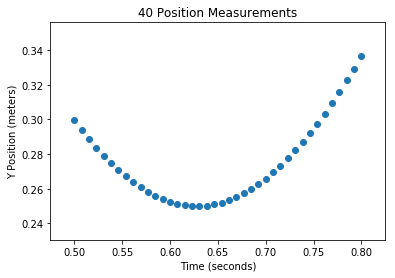

In [33]:
n_points_of_y(40)

Text(0.5,1,'Actual position graph')

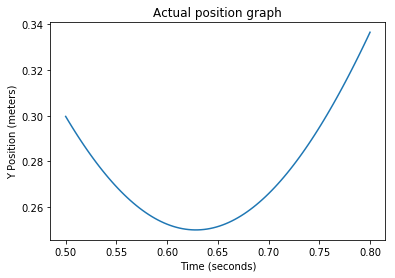

In [34]:
ts = np.linspace(0.5,0.8,100)
plt.plot(ts,[y(t) for t in ts])
plt.xlabel('Time (seconds)')
plt.ylabel('Y Position (meters)')
plt.title('Actual position graph')

In [35]:
def plot_function(f,xmin,xmax,color=None):
    ts = np.linspace(xmin,xmax,1000)
    plt.plot(ts,[f(t) for t in ts],c=color)

Text(0,0.5,'Y Position (meters)')

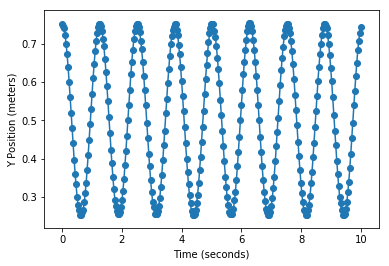

In [36]:
plot_function(y,0,10)
plt.scatter(spring_ts,spring_ys)
plt.xlabel('Time (seconds)')
plt.ylabel('Y Position (meters)')

In [37]:
spring_ts[0], spring_ys[0]

(0, 0.75)

In [38]:
from math import cos
def y(t):
    return 0.5 + 0.25 * cos(5*t)
y(0)

0.75

In [39]:
spring_ts[100]

3.3333333333333313

In [40]:
spring_ts[90]

2.999999999999999

In [41]:
spring_ys[90]

0.31333333333333335

In [42]:
y(3)

0.31007802178529464

Text(0,0.5,'Y Position (meters)')

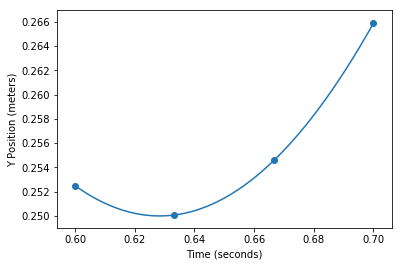

In [43]:
plot_function(y,0.6,0.7)
ts = [t for t in spring_ts if 0.6 <= t <= 0.7] #[0.4,0.5,0.6,0.7,0.8]
plt.scatter(ts, [y(t) for t in ts])
plt.xlabel('Time (seconds)')
plt.ylabel('Y Position (meters)')

-0.07269875102221048
0.13508744019245847
0.3391298806521193


Text(0,0.5,'Y Position (meters)')

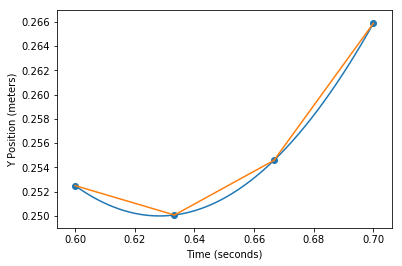

In [44]:
plot_function(y,0.6,0.7)
ts = [t for t in spring_ts if 0.6 <= t <= 0.7] #[0.4,0.5,0.6,0.7,0.8]
plt.scatter(ts, [y(t) for t in ts])
def secant(y,xmin,xmax):
    slope = (y(xmax) - y(xmin)) / (xmax - xmin)
    def linear_function(x):
        return slope * (x - xmin) + y(xmin)
    return linear_function
def secant_slope(f,xmin,xmax):
    return (f(xmax) - f(xmin)) / (xmax - xmin)

def plot_secant(y,xmin,xmax,color=None,points=False):
    plot_function(secant(y,xmin,xmax),xmin,xmax,color=color)
    if points:
        plt.scatter([xmin,xmax],[y(xmin),y(xmax)],c=color)
    
for t in ts[:-1]:
    plot_secant(y,t,t+(1/30),color='C1')
    print (interval_velocity(t,y(t),t+(1/30),y(t+(1/30))))
    
# plot_secant(y,0.5,0.7)
# plot_secant(y,0.5,0.6)
# plot_secant(y,0.6,0.7)

plt.xlabel('Time (seconds)')
plt.ylabel('Y Position (meters)')

-0.09869848481241164
0.05732669001140329
0.21245730101099738
0.3642725868865001


Text(0,0.5,'Y Position (meters)')

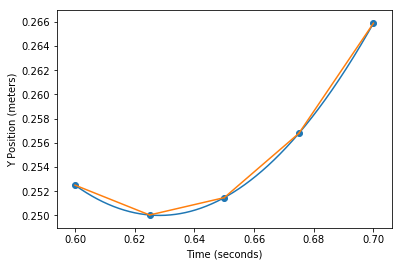

In [45]:
plot_function(y,0.6,0.7)
n = 4
ts = [t for t in np.linspace(0.6,0.7,n+1)]
plt.scatter(ts, [y(t) for t in ts])
dt = 0.1/n
for t in ts[:-1]:
    plot_secant(y,t,t+dt,color='C1')
    print (interval_velocity(t,y(t),t+dt,y(t+dt)))
plt.xlabel('Time (seconds)')
plt.ylabel('Y Position (meters)')

Text(0.5,0,'x')

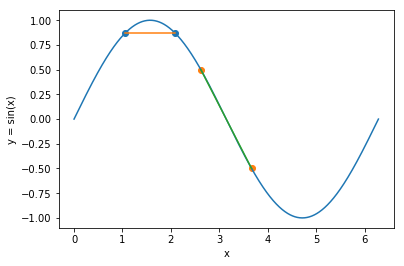

In [46]:
plot_function(sin,0,2*pi)
plt.scatter([2*pi/6,4*pi/6],[sin(2*pi/6),sin(4*pi/6)])
plot_secant(sin,2*pi/6,4*pi/6)

plt.scatter([5*pi/6,7*pi/6],[sin(5*pi/6),sin(7*pi/6)])
plot_secant(sin,5*pi/6,7*pi/6)

plt.ylabel('y = sin(x)')
plt.xlabel('x')

Text(0,0.5,'Y Position (meters)')

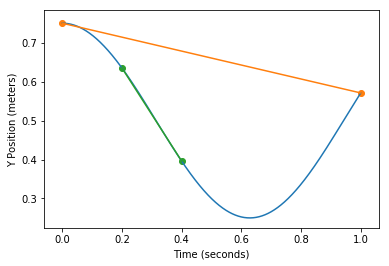

In [47]:
plot_function(y,0,1)
plot_secant(y,0,1,points=True,color='C1')
plot_secant(y,0.2,0.4,points=True,color='C2')
plt.xlabel('Time (seconds)')
plt.ylabel('Y Position (meters)')

In [48]:
secant_slope(y,0,1)

-0.17908445363419345

In [49]:
secant_slope(y,0.2,0.4)

-1.1955614280191025

Text(0,0.5,'Y Position (meters)')

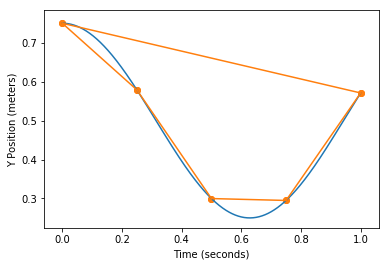

In [50]:
plot_function(y,0,1)
plot_secant(y,0,1,points=True,color='C1')
plot_secant(y,0,1/4,points=True,color='C1')
plot_secant(y,1/4,2/4,points=True,color='C1')
plot_secant(y,2/4,3/4,points=True,color='C1')
plot_secant(y,3/4,4/4,points=True,color='C1')
plt.xlabel('Time (seconds)')
plt.ylabel('Y Position (meters)')

Text(0,0.5,'Y Position (meters)')

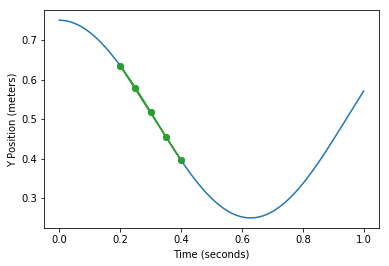

In [51]:
plot_function(y,0,1)
plot_secant(y,0.2,0.4,points=True,color='C2')
plot_secant(y,0.2,0.25,points=True,color='C2')
plot_secant(y,0.25,0.3,points=True,color='C2')
plot_secant(y,0.3,0.35,points=True,color='C2')
plot_secant(y,0.35,0.4,points=True,color='C2')
plt.xlabel('Time (seconds)')
plt.ylabel('Y Position (meters)')

Text(0,0.5,'Y Position (meters)')

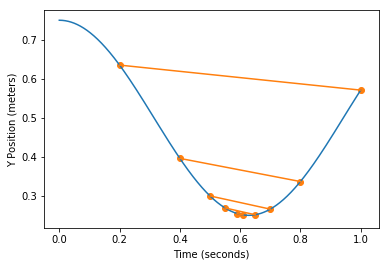

In [52]:
plot_function(y,0.0,1.0)
plot_secant(y,0.2,1.0,points=True,color='C1')
plot_secant(y,0.4,0.8,points=True,color='C1')
plot_secant(y,0.5,0.7,points=True,color='C1')
plot_secant(y,0.55,0.65,points=True,color='C1')
plot_secant(y,0.59,0.61,points=True,color='C1')
plt.xlabel('Time (seconds)')
plt.ylabel('Y Position (meters)')

Text(0,0.5,'Y Position (meters)')

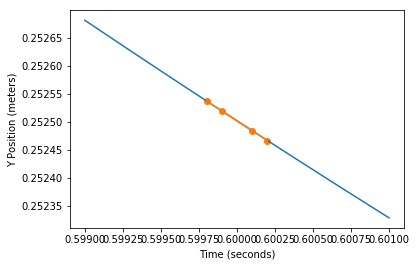

In [53]:
plot_function(y,0.599,0.601)
# plot_secant(y,0.59,0.61,points=True,color='C1')
# plot_secant(y,0.595,0.605,points=True,color='C1')
# plot_secant(y,0.599,0.601,points=True,color='C1')
plot_secant(y,0.5998,0.6002,points=True,color='C1')
plot_secant(y,0.5999,0.6001,points=True,color='C1')
# plot_secant(y,0.59,0.61,points=True,color='C1')
plt.xlabel('Time (seconds)')
plt.ylabel('Y Position (meters)')

In [54]:
secant_slope(y,0.5,0.7)

-0.1691413396798286

In [55]:
secant_slope(y,0.59,0.61)

-0.17632651925759119

In [56]:
secant_slope(y,0.599,0.601)

-0.17639927507573355

In [57]:
secant_slope(y,0.5999,0.6001)

-0.17640000272463874

In [58]:
secant_slope(y,0.59999,0.60001)

-0.17640001000445282

In [59]:
secant_slope(y,0.599999,0.600001)

-0.17640001006617012

13.0
12.25
12.009999999999998


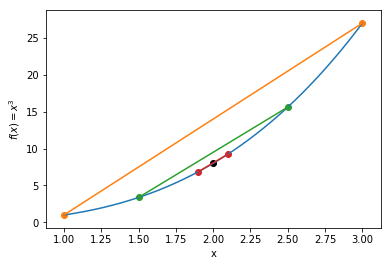

In [60]:
def f(x):
    return x**3

plot_function(f,1,3)
plt.xlabel('x')
plt.ylabel('$f(x) = x^3$')

plt.scatter([2],[f(2)],c='k')
plot_secant(f,1,3,points=True,color='C1')
print(secant_slope(f,1,3))
plot_secant(f,1.5,2.5,points=True,color='C2')
print(secant_slope(f,1.5,2.5))
plot_secant(f,1.9,2.1,points=True,color='C3')
print(secant_slope(f,1.9,2.1))

In [62]:
dx = 1e-6
secant_slope(y,0.6-dx,0.6+dx)

-0.17640001006617012

In [63]:
secant_slope(f,2-dx,2+dx)

12.00000000044409

In [66]:
def derivative_at_point(f,x,dx=1e-6):
    return secant_slope(f,x-dx,x+dx)

In [67]:
derivative_at_point(f,2)

12.00000000044409

In [68]:
def derivative(f, dx=1e-6):
    return lambda x: derivative_at_point(f,x,dx=dx)

In [69]:
f_derivative = derivative(f)

In [70]:
f_derivative(2)

12.00000000044409

In [71]:
vy = derivative(y)

Text(0,0.5,'Y Velocity (m/s)')

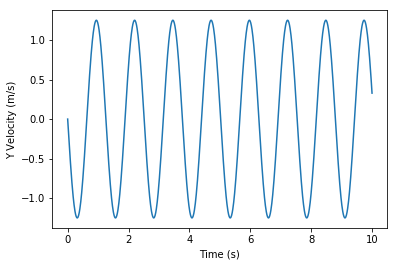

In [76]:
plot_function(vy,0,10)
plt.xlabel('Time (s)')
plt.ylabel('Y Velocity (m/s)')

In [77]:
vy(0.6)

-0.17640001006617012

Text(0,0.5,'Y Velocity (m/s)')

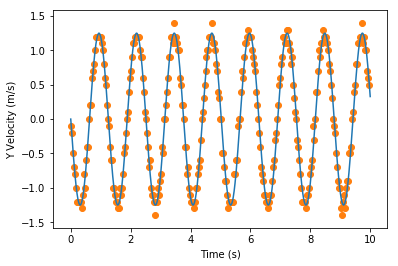

In [79]:
plot_function(vy,0,10)
plt.scatter(spring_ts[:-1],spring_vys,c='C1')
plt.xlabel('Time (s)')
plt.ylabel('Y Velocity (m/s)')

Text(0.5,0,'Time (s)')

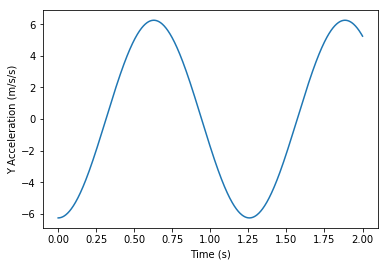

In [99]:
plot_function(derivative(vy),0,2)
plt.ylabel('Y Acceleration (m/s/s)')
plt.xlabel('Time (s)')

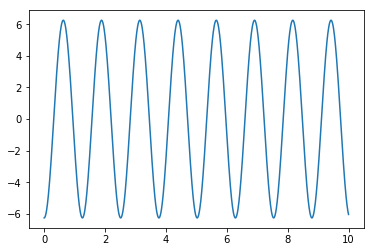

In [82]:
plot_function(derivative(derivative(y)),0,10)

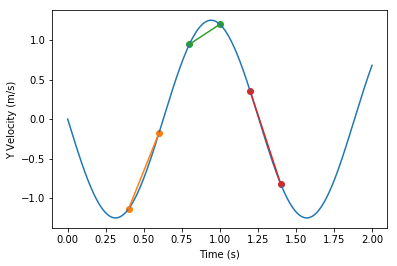

In [95]:
plot_function(vy,0,2)
plt.xlabel('Time (s)')
plt.ylabel('Y Velocity (m/s)')
plot_secant(vy,0.4,0.6,points=True, color='C1')
plot_secant(vy,0.8,1.0,points=True, color='C2')
plot_secant(vy,1.2,1.4,points=True, color='C3')

Text(0,0.5,'Y Position (meters)')

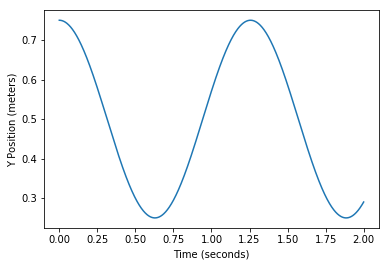

In [96]:
plot_function(y,0,2)
plt.xlabel('Time (seconds)')
plt.ylabel('Y Position (meters)')

Text(0.5,0,'Time (seconds)')

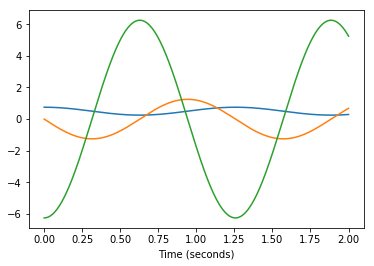

In [103]:
ay = derivative(vy)
plot_function(y,0,2)
plot_function(vy,0,2)
plot_function(ay,0,2)
plt.xlabel('Time (seconds)')